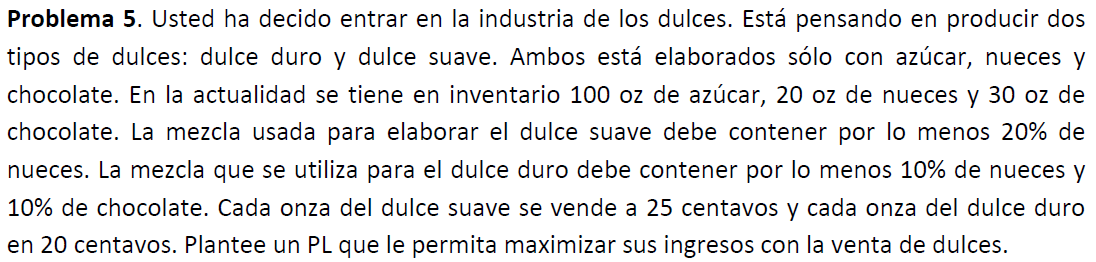

## Sets
I es el conjunto de ingredientes (i = 1 es azúcar, i = 2 es nueces, i = 3 es chocolate)\
J es el conjunto de dulces (j = 1 es dulce duro, j = 2 es dulce suave)

In [39]:
import pyomo.environ as pe
import pyomo.opt as po

In [40]:
model = pe.ConcreteModel()

In [41]:
I = set(range(1,4))
J = set(range(1,3))

In [42]:
model.I = pe.Set(initialize = I)
model.J = pe.Set(initialize = J)

    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo
    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo


## Parameters
Ingj es el ingreso unitario por la venta del dulce j (dolar/unidad)\
Invi es la cantidad de onzas del ingrediente i en inventario (Oz)\
PMinij es el requerimiento mínimo de onzas del ingrediente i contenidas en el dulce j (%)

In [43]:
Ing = {1: 20, 2: 25}
Inv = {1: 100, 2: 20, 3: 30}
PM = {(1,1): 0,   (1,2): 0,
      (2,1): 0.1, (2,2): 0.2,
      (3,1): 0.1, (3,2): 0}

In [44]:
model.Ing = pe.Param(model.J, initialize = Ing) #Ingreso unitario
model.Inv = pe.Param(model.I, initialize = Inv) #Onzas en inventario
model.PM = pe.Param(model.I, model.J, initialize = PM) #Requerimiento mínimo

## Variables
xij es la cantidad de onzas del ingrediente i usadas para producir el tipo de dulce j

In [45]:
model.x = pe.Var(model.I, model.J, domain = pe.NonNegativeReals)

## Objective

In [46]:
Z = sum(model.Ing[j] * model.x[i,j] 
        for i in model.I for j in model.J)
model.objective = pe.Objective(sense = pe.maximize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : 20*x[1,1] + 25*x[1,2] + 20*x[2,1] + 25*x[2,2] + 20*x[3,1] + 25*x[3,2]


## Constraints

In [47]:
model.inventario = pe.ConstraintList()
for i in model.I:
    inv_lhs = sum(model.x[i,j] for j in model.J)
    inv_rhs = model.Inv[i]
    model.inventario.add(inv_lhs <= inv_rhs)
model.inventario.pprint()

inventario : Size=3, Index=inventario_index, Active=True
    Key : Lower : Body            : Upper : Active
      1 :  -Inf : x[1,1] + x[1,2] : 100.0 :   True
      2 :  -Inf : x[2,1] + x[2,2] :  20.0 :   True
      3 :  -Inf : x[3,1] + x[3,2] :  30.0 :   True


In [48]:
model.reqMin = pe.ConstraintList()
model.K = pe.SetOf(model.I)
for i in model.I:
    for j in model.J:
        req_lhs = model.x[i,j]
        req_rhs = model.PM[i,j]*sum(model.x[k,j] for k in model.K)
        model.reqMin.add(req_lhs >= req_rhs)
model.reqMin.pprint()

reqMin : Size=6, Index=reqMin_index, Active=True
    Key : Lower : Body                                    : Upper : Active
      1 :   0.0 :                                  x[1,1] :  +Inf :   True
      2 :   0.0 :                                  x[1,2] :  +Inf :   True
      3 :  -Inf : 0.1*(x[1,1] + x[2,1] + x[3,1]) - x[2,1] :   0.0 :   True
      4 :  -Inf : 0.2*(x[1,2] + x[2,2] + x[3,2]) - x[2,2] :   0.0 :   True
      5 :  -Inf : 0.1*(x[1,1] + x[2,1] + x[3,1]) - x[3,1] :   0.0 :   True
      6 :   0.0 :                                  x[3,2] :  +Inf :   True


## Solver

In [49]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpct6m800o.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpc8mw55hu.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpke9zgcil.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpke9zgcil.pyomo.lp'...
10 rows, 7 columns, 19 non-zeros
69 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpc8mw55hu.glpk.glp'...
55 lines were written
GLPK Simplex Optimizer 5.0
10 rows, 7 columns, 19 non-zeros
Preprocessing...
6 rows, 6 columns, 15 non-zeros
Scaling...
 A: min|aij| =  1.000e-01  max|aij| =  1.000e+00  ratio =  1.000e+01
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6
*     0: obj =  -0.000000000e+00 inf =   0.000e+00 (6)
*     6: obj =   3.250000000e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0

In [52]:
for i in model.I:
    for j in model.J:
        print(pe.value(model.x[i,j]))
print(pe.value(model.objective))

60.0
40.0
10.0
10.0
30.0
0.0
3250.0
